### 数学建模案例分析：量化投资的投资组合分析

**后面花时间, 对这块需仔细研究**

GitModel公司根据客户的要求，选定了 600000 浦发银行， 600004 白云机场， 600019 宝钢股份， 600028 中国石化， 600030 中信证券五个股票为一篮子股票。投资者都是风险厌恶型（Risk averse），那么在同等收益水平下，他们会选择风险更小的资产。同理，当风险水平相同，投资者们会倾向于选择高收益资产，因此客户希望按照风险最小原则计算各个股票的最优投资比例。

login success!
login respond error_code:0
login respond  error_msg:success
query_history_k_data_plus respond error_code:0
query_history_k_data_plus respond  error_msg:success
query_history_k_data_plus respond error_code:0
query_history_k_data_plus respond  error_msg:success
query_history_k_data_plus respond error_code:0
query_history_k_data_plus respond  error_msg:success
query_history_k_data_plus respond error_code:0
query_history_k_data_plus respond  error_msg:success


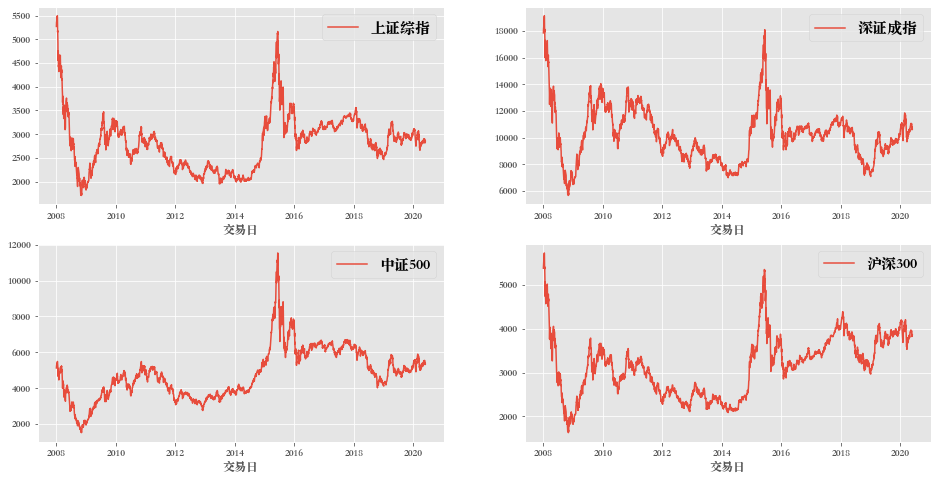

In [ ]:
# 学会使用baostock获取金融数据
import numpy as np
import pandas as pd
import baostock as bs
plt.style.use('ggplot')
# 登陆系统
lg = bs.login()
# 显示登陆返回信息
print('login respond error_code:'+lg.error_code)
print('login respond  error_msg:'+lg.error_msg)

# 获取指数(综合指数、规模指数、一级行业指数、二级行业指数、策略指数、成长指数、价值指数、主题指数)K线数据
# 综合指数，例如：sh.000001 上证指数，sz.399106 深证综指 等；
# 规模指数，例如：sh.000016 上证50，sh.000300 沪深300，sh.000905 中证500，sz.399001 深证成指等；
# 一级行业指数，例如：sh.000037 上证医药，sz.399433 国证交运 等；
# 二级行业指数，例如：sh.000952 300地产，sz.399951 300银行 等；
# 策略指数，例如：sh.000050 50等权，sh.000982 500等权 等；
# 成长指数，例如：sz.399376 小盘成长 等；
# 价值指数，例如：sh.000029 180价值 等；
# 主题指数，例如：sh.000015 红利指数，sh.000063 上证周期 等；

# 详细指标参数，参见“历史行情指标参数”章节
index_list = []
stock_codes = ['sh.000001','sz.399001','sh.000905','sh.000300']
stock_names = ['上证综指','深证成指','中证500','沪深300']
for i in stock_codes:
    rs = bs.query_history_k_data_plus(i,
    "date,code,open,high,low,close,preclose,volume,amount,pctChg",
    start_date='2008-01-02', end_date='2020-05-28', frequency="d")
    print('query_history_k_data_plus respond error_code:'+rs.error_code)
    print('query_history_k_data_plus respond  error_msg:'+rs.error_msg)
    # 打印结果集
    data_list = []
    while (rs.error_code == '0') & rs.next():
        # 获取一条记录，将记录合并在一起
        data_list.append(rs.get_row_data())
    result = pd.DataFrame(data_list, columns=rs.fields)
    result['date'] = pd.to_datetime(result['date'])
    result['close'] = result['close'].astype("float")
    index_list.append(result[['date','close']])
# 绘图
plt.figure(figsize=(16,8))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.plot(index_list[i]['date'],index_list[i]['close'],c="#e74c3c")
    plt.legend((stock_names[i],),loc = 'best',fontsize=15)
    plt.xlabel('交易日')
    plt.xticks()
plt.show()

在建模前，先介绍几个相关的金融概念：
- 股票的收益：所谓收益，其实就是股票的买入价和卖出价之差，如果每天都进行交易，那么股票的日收益就是交易当天的收盘价减去昨日收盘价，即：$y_t - y_{t-1}$；
- 股票的收益率：收益率就是收益的比率版本，即：$r_t = \frac{y_t-y_{t-1}}{y_{t-1}}$
- 股票的对数收益率：大多数时候，我们不会直接使用收益率，而是使用对数收益率，即：
$$
r_t = \frac{y_t-y_{t-1}}{y_{t-1}} = \frac{y_{t}}{y_{t-1}}-1 \sim ln(\frac{y_{t}}{y_{t-1}})
$$
- 为什么要使用对数收益率而不是直接使用收益率呢？对数收益率在直观上更接近真实的表现。比如股票价格从 1 元涨到 10 元， 相当于翻了 10 倍， 再从 10 元涨到 100 元， 也是翻了 10 倍。如果单纯计算收益率, 那么从 10 元涨到 100 元的这一段明显会 “看起来涨了更多”。如果换算成对数收益率，都是$ln(10)$ ，那么就不会有这种直观偏差。
- 股票的预期收益率：预期收益率也称为期望收益率，是指如果没有意外事件发生时根据已知信息所预测能得到的收益率。最简单的情况，其实就是历史收益率的数学期望，表示如果没有意外情况还会按照历史平均收益情况进行变化。
- 股票的风险：所谓风险，就是收益率的波动情况，衡量波动最简单的方式就是使用标准差$\sigma$。

假设存在一个投资组合， 它由$N$只股票构成， 描述一个投资组合需要用到包括投资组合的预期收益率以及投资组合收益率的波动率两个重要的变量。
1. 投资组合的预期收益率
$$
\begin{gathered}
E\left(R_{p}\right)=E\left(\sum_{i=1}^{N} w_{i} R_{i}\right)=\sum_{i=1}^{N} w_{i} E\left(R_{i}\right) \\
=\left[w_{1}, w_{2}, \ldots, w_{N}\right]\left[E\left(R_{1}\right), E\left(R_{2}\right), \ldots, E\left(R_{N}\right)\right]^{T}
\end{gathered}
$$
其中， $E\left(R_{p}\right)$ 代表了投资组合的预期收益率， $w_{i}$ 代表了投资组合中第 $i$ 只股票所占的权重， 通常是股票的市值占投资组合整体市值的比例，
同时： $\sum_{i=1}^{N} w_{i}=1, E\left(R_{i}\right.$ )代表了投资组合中第 $i$ 只股票的预期收益率， 通常用该股票过去收益率的均值代替; $\left[w_{1}, w_{2}, \ldots, w_{N}\right]$ 代表了每只股票权重的向量； $\left[E\left(R_{1}\right), E\left(R_{2}\right), \ldots, E\left(R_{N}\right)\right]^{T}$ 代表了每只股票预期收益率的向量 (列向量) 在计算 $R_{i t}$ 即第 $i$ 只股票在第 $t$ 个交易日的收益率时， 常使用对数收益率（连续复利的收益率) : $R_{i t}=\ln \left(\frac{P_{i t}}{P_{i t-1}}\right)$。

 $P_{i t}$ 表示第 $i$ 个股票在第 $t$ 个时刻的价格， $P_{i t-1}$ 表示第 $i$ 个股票在第 $t-1$ 个时刻的价格。

按照一般规律：
周波动率 $=\sqrt{5} \times$ 日波动率，月波动率 $=\sqrt{22} \times$ 日波动率，年波动率 $=\sqrt{252} \times$ 日波动率。

2. 投资组合的波动率 (风险)
考虑 $N$ 个股票的收益波动率：
$$
\sigma_{p}=\sqrt{\sum_{i=1}^{N} \sum_{j=1}^{N} w_{i} w_{j} \operatorname{Cov}\left(R_{i}, R_{j}\right)}
$$
由于相关系数 $\rho_{i j}=\frac{\operatorname{Cov}\left(R_{i}, R_{j}\right)}{\sigma_{i} \sigma_{j}}$， 因此 $\sigma_{p}=\sqrt{\sum_{i=1}^{N} \sum_{j=1}^{N} \rho_{i j} w_{i} w_{j} \sigma_{i} \sigma_{j}}$。

写成矩阵的形式: $\sigma_{p}=\sqrt{w \Sigma w^{T}}$, 其中 $w=\left[w_{1}, w_{2}, \ldots, w_{N}\right], \Sigma=\left[\begin{array}{cccc}\sigma_{1}^{2} & \sigma_{12} & \cdots & \sigma_{1 N} \\ \sigma_{21} & \sigma_{2}^{2} & \cdots & \sigma_{2 N} \\ \vdots & \vdots & \ddots & \vdots \\ \sigma_{N 1} & \sigma_{N 2} & \cdots & \sigma_{N}^{2}\end{array}\right]$

那什么是最优投资组合呢？其实十分简单：期望收益下的风险最小的组合。有效前沿是可行集的一条包络线，他表示了在不同的风险条件下能够给投资者带来的最高预期收益率，或者在不同预测收益条件下能够给投资者带来的最低波动率（风险）。其实有效前沿就是求解以下最优条件:
$$
\min _{w_{i}} \sigma_{p}=\min _{w_{i}} \sqrt{\sum_{i=1}^{N} \sum_{j=1}^{N} w_{i} w_{j} \operatorname{Cov}\left(R_{i}, R_{j}\right)}
$$
约束条件是： $\left\{\begin{array}{l}\sum_{i=1}^{N} w_{i}=1 \quad \text{组合内每个股票投资比例之和为1}\\ E\left(R_{p}\right)=E\left(\sum_{i=1}^{N} w_{i} R_{i}\right)\quad \text{客户想要的收益率} \\ w_{i}>0 \text { (不允许卖空（不允许借入股票）, 即不允许融券) }\end{array}\right.$

In [ ]:
# 获取组合股票数据： 600000 浦发银行， 600004 白云机场， 600019 宝钢股份， 600028 中国石化， 600030 中信证券

#### 获取沪深A股历史K线数据 ####
# 详细指标参数，参见“历史行情指标参数”章节；“分钟线”参数与“日线”参数不同。
# 分钟线指标：date,time,code,open,high,low,close,volume,amount,adjustflag
stock_codes = ['sh.600000','sh.600004','sh.600019','sh.600028','sh.600030']
stock_datalist = []
for i in stock_codes:
    rs = bs.query_history_k_data_plus(i,
        "date,close",
        start_date='2016-01-01', end_date='2021-12-31',
        frequency="d", adjustflag="3")
    print('query_history_k_data_plus respond error_code:'+rs.error_code)
    print('query_history_k_data_plus respond  error_msg:'+rs.error_msg)

    #### 打印结果集 ####
    data_list = []
    while (rs.error_code == '0') & rs.next():
        # 获取一条记录，将记录合并在一起
        data_list.append(rs.get_row_data())
    result = pd.DataFrame(data_list, columns=rs.fields)
    stock_datalist.append(result)
    print(result)

query_history_k_data_plus respond error_code:0
query_history_k_data_plus respond  error_msg:success
            date    close
0     2016-01-04  17.8000
1     2016-01-05  17.9600
2     2016-01-06  18.1000
3     2016-01-07  17.5100
4     2016-01-08  17.4900
...          ...      ...
1456  2021-12-27   8.5600
1457  2021-12-28   8.5700
1458  2021-12-29   8.5400
1459  2021-12-30   8.5400
1460  2021-12-31   8.5300

[1461 rows x 2 columns]
query_history_k_data_plus respond error_code:0
query_history_k_data_plus respond  error_msg:success
            date    close
0     2016-01-04  13.0400
1     2016-01-05  13.1400
2     2016-01-06  13.4300
3     2016-01-07  12.4200
4     2016-01-08  12.7000
...          ...      ...
1456  2021-12-27  11.7100
1457  2021-12-28  11.6000
1458  2021-12-29  12.0000
1459  2021-12-30  12.0300
1460  2021-12-31  12.0600

[1461 rows x 2 columns]
query_history_k_data_plus respond error_code:0
query_history_k_data_plus respond  error_msg:success
            date   close
0

date    object
浦发银行    object
白云机场    object
宝钢股份    object
中国石化    object
中信证券    object
dtype: object
date    datetime64[ns]
浦发银行           float64
白云机场           float64
宝钢股份           float64
中国石化           float64
中信证券           float64
dtype: object


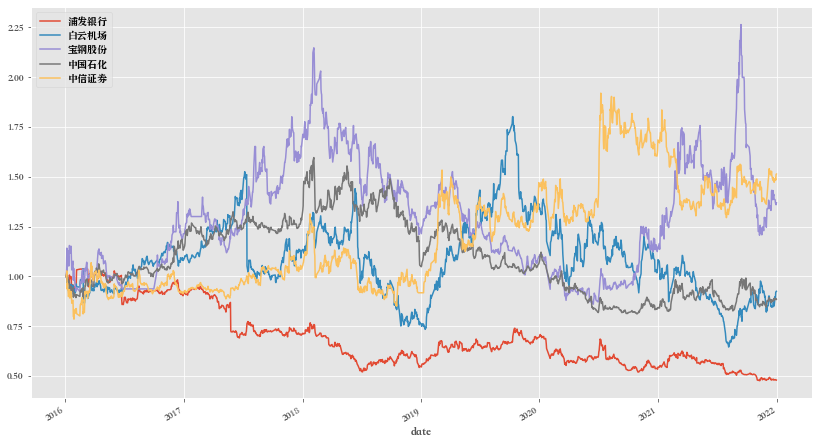

In [ ]:
# 处理数据 
data_stock = pd.DataFrame(
    {
        'date': stock_datalist[0]['date'],
        '浦发银行': stock_datalist[0]['close'],
        '白云机场': stock_datalist[1]['close'],
        '宝钢股份': stock_datalist[2]['close'],
        '中国石化': stock_datalist[3]['close'],
        '中信证券': stock_datalist[4]['close'],
    }
)
print(data_stock.dtypes)  #转换数据格式
data_stock['date'] = pd.to_datetime(data_stock['date'])
data_stock['浦发银行'] = data_stock['浦发银行'].astype('float')
data_stock['白云机场'] = data_stock['白云机场'].astype('float')
data_stock['宝钢股份'] = data_stock['宝钢股份'].astype('float')
data_stock['中国石化'] = data_stock['中国石化'].astype('float')
data_stock['中信证券'] = data_stock['中信证券'].astype('float')
print(data_stock.dtypes)  

data_stock = data_stock.set_index('date')
# 归一化
(data_stock/data_stock.iloc[0]).plot(figsize=(14,8))
plt.show()

In [ ]:
# 计算对数收益率
R = np.log(data_stock/data_stock.shift(1)) # log(y_t) - log(y_{t-1})
R = R.dropna()
R.describe()

,浦发银行,白云机场,宝钢股份,中国石化,中信证券
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,-0.000504,-0.000054,0.000215,-0.000084,0.000284
std,0.013782,0.023718,0.022161,0.013956,0.020667
min,-0.179352,-0.362493,-0.104747,-0.072812,-0.105527
25%,-0.006227,-0.011185,-0.010091,-0.006659,-0.008934
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.005100,0.010945,0.010133,0.006817,0.009017
max,0.086415,0.095634,0.095648,0.071707,0.095578


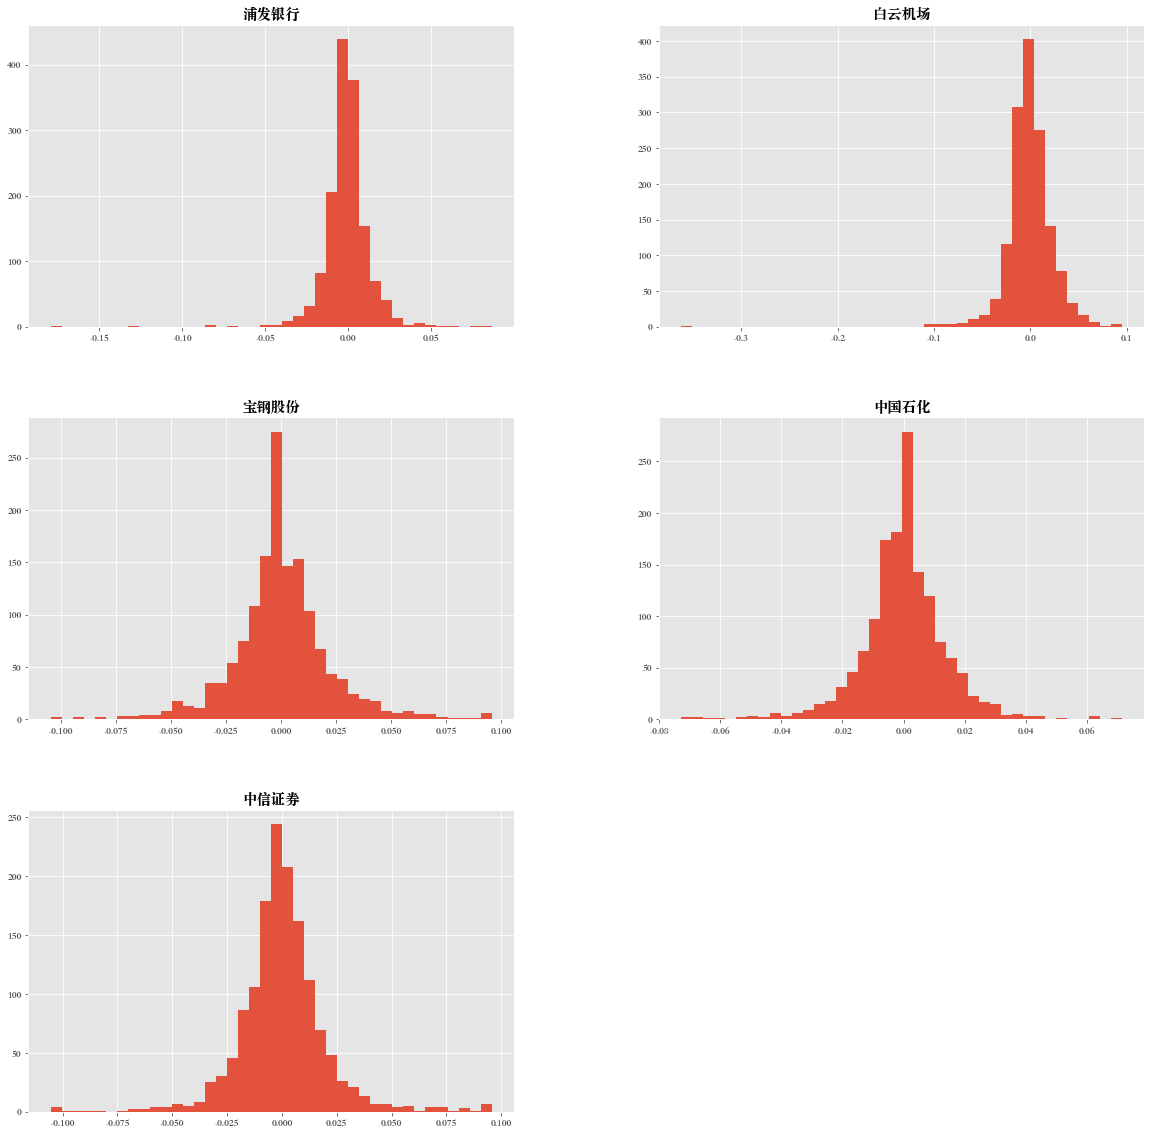

In [ ]:
# 可视化对数收益率
R.hist(bins=40,figsize=(20,20),alpha=0.95)
plt.show()

In [ ]:
# 计算每只股票的平均收益率
R_mean = R.mean()*252   # 计算股票的平均年化收益率
print("平均年化收益率:\n",R_mean)

平均年化收益率:
 浦发银行   -0.126968
白云机场   -0.013485
宝钢股份    0.054214
中国石化   -0.021099
中信证券    0.071527
dtype: float64


In [ ]:
#计算每只股票的波动率，协方差
R_cov = R.cov()*252   # 计算股票的协方差矩阵并且年化处理
print("协方差矩阵")
R_cov

协方差矩阵


,浦发银行,白云机场,宝钢股份,中国石化,中信证券
浦发银行,0.047869,0.020379,0.022801,0.017419,0.031552
白云机场,0.020379,0.141760,0.034336,0.021096,0.049400
宝钢股份,0.022801,0.034336,0.123759,0.034540,0.046216
中国石化,0.017419,0.021096,0.034540,0.049082,0.029506
中信证券,0.031552,0.049400,0.046216,0.029506,0.107633


In [ ]:
# 计算每个股票的相关系数矩阵
R_corr = R.corr()    # 计算股票的相关系数矩阵
print("相关系数矩阵:")
R_corr

相关系数矩阵:


,浦发银行,白云机场,宝钢股份,中国石化,中信证券
浦发银行,1.000000,0.247388,0.296233,0.359359,0.439562
白云机场,0.247388,1.000000,0.259232,0.252913,0.399929
宝钢股份,0.296233,0.259232,1.000000,0.443169,0.400437
中国石化,0.359359,0.252913,0.443169,1.000000,0.405954
中信证券,0.439562,0.399929,0.400437,0.405954,1.000000


In [ ]:
# 计算每个股票的年化收益波动率
R_vol = R.std()*np.sqrt(252)  # 计算股票收益率的年化波动率(方差)
print('股票收益率的年化波动率(方差):\n',R_vol)

股票收益率的年化波动率(方差):
 浦发银行    0.218790
白云机场    0.376510
宝钢股份    0.351794
中国石化    0.221545
中信证券    0.328074
dtype: float64


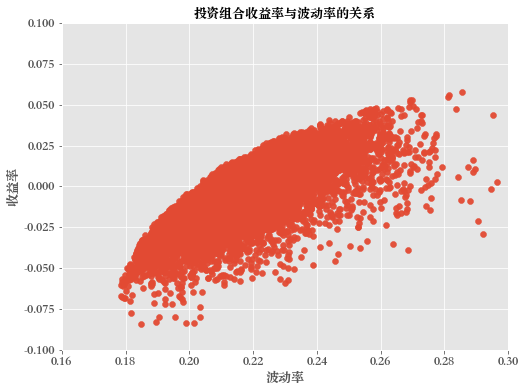

In [ ]:
# 1. 绘制可行集,每种波动率条件下的收益率变化
Rp_list = []   # 初始的投资组合收益率数组
Vp_list = []   # 初始的投资组合收益波动率数组
for i in np.arange(10000):   # 生成1000个不同权重的预期收益率和收益波动率
    x = np.random.random(5)
    weight = x/np.sum(x)
    Rp_list.append(np.sum(weight*R_mean))
    Vp_list.append(np.sqrt(np.dot(weight,np.dot(R_cov,weight.T))))
plt.figure(figsize=(8,6))
plt.scatter(Vp_list,Rp_list,alpha=0.95)
plt.xlabel(u"波动率",fontsize=13)
plt.ylabel(u'收益率',fontsize=13,rotation=90)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlim(0.16,0.3)
plt.ylim(-0.1,0.1)
plt.title(u'投资组合收益率与波动率的关系',fontsize=13)
plt.show()

In [ ]:
# 构建有限前沿
import scipy.optimize as sco

def f(w):  # 构建最优化函数
    w = np.array(w)
    Rp_opt = np.sum(w*R_mean)
    Vp_opt = np.sqrt(np.dot(w,np.dot(R_cov,w.T))) 
    return np.array([Rp_opt,Vp_opt])

def Vmin_f(w):   # 获得最小波动率
    return f(w)[1]

cons = ({'type':'eq','fun':lambda x:np.sum(x)-1}) # 所有权重和为1
bnds = tuple((0,1) for x in range(len(R_mean))) # 每个权重必须要在区间(0,1)

result = sco.minimize(Vmin_f,len(R_mean)*[1.0/len(R_mean)],method='SLSQP',bounds=bnds,constraints=cons)
print("投资组合预期收益率 10% 时浦发银行的权重",round(result['x'][0],4))
print("投资组合预期收益率 10% 时白云机场的权重",round(result['x'][1],4))
print("投资组合预期收益率 10% 时宝钢股份的权重",round(result['x'][2],4))
print("投资组合预期收益率 10% 时中国石化的权重",round(result['x'][3],4))
print("投资组合预期收益率 10% 时中信证券的权重",round(result['x'][4],4))

投资组合预期收益率 10% 时浦发银行的权重 0.4587
投资组合预期收益率 10% 时白云机场的权重 0.0877
投资组合预期收益率 10% 时宝钢股份的权重 0.0294
投资组合预期收益率 10% 时中国石化的权重 0.4242
投资组合预期收益率 10% 时中信证券的权重 0.0


In [ ]:
Rp_vmin = np.sum(R_mean*result['x'])
Vp_vmin = result['fun']
print('波动率在可行集是全局最小值的投资组合预期收益率',round(Rp_vmin,4))
print('在可行集是全局最小值的波动率',round(Vp_vmin,4))

波动率在可行集是全局最小值的投资组合预期收益率 -0.0668
在可行集是全局最小值的波动率 0.1782


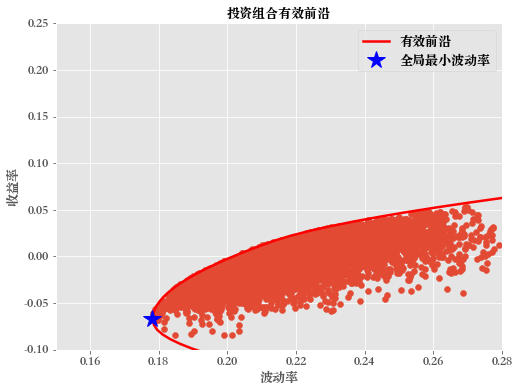

In [ ]:
# 绘制有效前沿
Rp_target = np.linspace(-0.2,0.3,100)   
Vp_target = []
for r in Rp_target:
    cons_new = ({'type':'eq','fun':lambda x:np.sum(x)-1},{'type':'eq','fun':lambda x:f(x)[0]-r})
    bnds = tuple((0,1) for x in range(len(R_mean))) # 每个权重必须要在区间(0,1)
    result_new = sco.minimize(Vmin_f,len(R_mean)*[1.0/len(R_mean),],method='SLSQP',bounds=bnds,constraints=cons_new)
    Vp_target.append(result_new['fun'])
plt.figure(figsize=(8,6))
plt.scatter(Vp_list,Rp_list)
plt.plot(Vp_target,Rp_target,'r-',label=u'有效前沿',lw=2.5)
plt.plot(Vp_vmin,Rp_vmin,'b*',label=u'全局最小波动率',markersize=18)
plt.xlabel(u'波动率',fontsize=13)
plt.ylabel(u'收益率',fontsize=13,rotation=90)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlim(0.15,0.28)
plt.ylim(-0.1,0.25)
plt.title(u'投资组合有效前沿',fontsize=13)
plt.legend(fontsize=13)
plt.show()

我们刚刚构建的组合都是基于有风险的资产，如：股票等，并没涉及无风险资产，如：国债、存款等.
<div class="alert alert-warning" role="alert">
  <h3>📋任务</h3> 
    现在大家可以将无风险资产纳入投资组合中，存在无风险资产时，投资者可以通过贷出自有资金减少自己的风险，当然这样会降低期望报酬率；也可以通过借入资金，增加购买风险资产的投入资金，从而提高期望报酬率。这样也就意味着投资者可以按照无风险利率借入或者借出任何数量的资金， 这样就引出的是：<strong>资产市场线</strong>.
</div>

假设投资组合的风险资产$M$和无风险资产资产$F$，设$R_M$为风险资产收益率，风险资产的期望收益$E(R_M)$，风险资产的波动率为：$\sigma_M$，无风险资产的收益率为$R_F$，无风险资产的波动率为0（无风险）。

假设风险资产与无风险资产的投资比例为$y$和$1-y$，那么整个组合的收益率为：$R_p = yE(R_M)+(1-y)R_F = R_F+y[E(R_M)-R_F]$。因此整个组合的预期收益率为：
$$
E(R_p) = R_F+y[E(R_M)-R_F]
$$
整个组合的波动率为：
$$
\sigma_p = y\sigma_M
$$
因此，$y = \frac{\sigma_p}{\sigma_M}$，代入整个组合的预期收益率方程得：$E(R_p) = R_F+[E(R_M)-R_F]\frac{\sigma_p}{\sigma_M}$，我们把$\frac{E(R_M)-R_F}{\sigma_M}$称为夏普比率，夏普比率就是整个组合预期收益率直线的斜率，我们希望斜率越大越好，这样获得的收益就会越大。

$\frac{E\left(R_{M}\right)-R_{F}}{\sigma_{M}}$ 是资本市场线的斜率, 也就是夏普比率 (Sharpe Ratio)。

因此：计算资本市场线的斜率就是求解以下优化问题：
$$
\max _{w_{i}} \frac{E\left(R_{M}\right)-R_{F}}{\sigma_{M}} 
$$
约束为$\sum_{i=1}^{N} w_{i}=1$，其中$w_i$为第$i$种风险资产在风险资产组合中的比例。


In [ ]:
# 求解资本市场线(请在“----------------”处补全代码)
def F(w):
    Rf = 0.02
    w = np.array(w)
    # 请根据风险组合的预期收益率公式补全以下代码
    RM_opt = -------------------------   # E(R_M)
    # 请根据市场组合的波动率补全以下代码
    VM_opt = -------------------------- # sigma_M
    # 请根据夏普比率公式补全以下代码
    SR = --------------------------
    return np.array([RM_opt,VM_opt,SR])

# 最大值等于最小化负的最小值
def SRmin_F(w):
    return -F(w)[2]

# 请根据约束：所有风险组合的投资比例和为1的约束补全以下代码
cons_SR = ({'type':---------------,'fun':lambda x:---------------})
bnds = tuple((0,1) for x in range(len(R_mean))) # 每个权重必须要在区间(0,1)，禁止卖空
# 请根据最优化的目标表达式和约束条件补全以下代码
result_SR = sco.minimize(-------------------------------)
Rf = 0.02
slope = -result_SR['fun']   # 资本市场线斜率
Rm = np.sum(R_mean*result_SR['x'])   #计算风险组合的预期收益率
Vm = (Rm-Rf) / slope # #计算风险组合的波动率
print('市场组合的预期收益率',round(Rm,4))
print('市场组合的波动率',round(Vm,4))

市场组合的预期收益率 0.0678
市场组合的波动率 0.2962


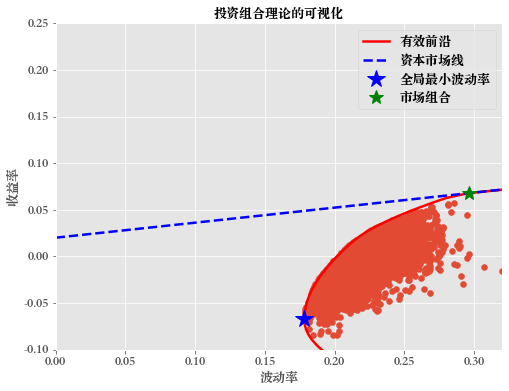

In [ ]:
# 资本市场线可视化
Rp_cml = np.linspace(0.02,0.25)   
Vp_cml = (Rp_cml-Rf) / slope

plt.figure(figsize=(8,6))
plt.scatter(Vp_list,Rp_list)
plt.plot(Vp_target,Rp_target,'r-',label=u'有效前沿',lw=2.5)
plt.plot(Vp_cml,Rp_cml,'b--',label=u'资本市场线',lw=2.5)
plt.plot(Vp_vmin,Rp_vmin,'b*',label=u'全局最小波动率',markersize=18)
plt.plot(Vm,Rm,'g*',label=u'市场组合',markersize=14)
plt.xlabel(u'波动率',fontsize=13)
plt.ylabel(u'收益率',fontsize=13,rotation=90)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlim(0,0.32)
plt.ylim(-0.1,0.25)
plt.title(u'投资组合理论的可视化',fontsize=13)
plt.legend(fontsize=13)
plt.show()


在蓝色的资本市场线上，当$x=0$时，代表购入全部的资产都是无风险资产，绿色的市场组合点表示所有资金都投资风险资产，因此在资本市场线上可以出现以下情况：
| 风险资产占总投资资产的投资比例 | 投资情况                    | 期望报酬率     | 风险     |
| :-------------- | :---------------------- | :-------- | :----- |
| y > 1           | 把自有资金与借入资金都投入风险投资       | 高于市场报酬率   | 高于市场风险 |
| y = 1           | 把自有资金全部投入风险投资           | 等于市场报酬率   | 等于市场风险 |
| y < 1           | 把自有资金部分投资风险资产，部分投资无风险资产 | 低于市场报酬率   | 低于市场风险 |
| y = 0           | 把自有资产全部投资于无风险资产         | 等于无风险资产利率 | 无风险    |

资本市场线实际上指出了有效投资组合风险与预期收益率之间的关系，提供了衡量有效投资组合风险的方法。对于每一个有效投资组合而言，给定其风险的大小，便可根据资本市场线知道其预期收益率的大小。